## **PROJETO**

**Problema:**

*   Criar programa para detectar placas de carro em foto e aplicar transformação para deixar mais fácil de ler, tanto para humanos quanto para processos automatizados. 

**Ex:** câmera de trânsito


**Objetivos:**

*   detectar placa de carro
*   modificar imagem para ficar facilmentee legivel

**Solução:**

*   detectar o retângulo que é o contorno da placa em cada imagem, calcular uma homografia usando a equivalência, e aplicar uma distorção de perspectiva, transformando a imagem analisada em uma vista reta da placa
*   aplicar um algorítmo para separar claramente as letras/números da placa (equalisar histograma, aplicar threshhold e aplicar erosão)

Primeiro configura o ambiente e define funções úteis




In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import random as rng
import math

In [6]:
def explode_xy(xy):
    xl=[]
    yl=[]
    for i in range(len(xy)):
        xl.append(xy[i][0][0])
        yl.append(xy[i][0][1])
    return xl,yl

def shoelace_area(xy):
    x_list,y_list = explode_xy(xy)
    a1,a2=0,0
    x_list.append(x_list[0])
    y_list.append(y_list[0])
    for j in range(len(x_list)-1):
        a1 += x_list[j]*y_list[j+1]
        a2 += y_list[j]*x_list[j+1]
    l=abs(a1-a2)/2
    return l

In [7]:
def get_biggest(xy):
  max = []
  maxarea = 0
  for i in range(len(xy)):
    area = shoelace_area(xy[i])
    if area > maxarea:
      max = xy[i]
      maxarea = area
  return max


def order_rect(xy): 
  #print(xy.shape)
  rect = xy.copy()
  #print(rect)
  for i in range(len(xy)):
    if i != len(xy)-1:
      nex = i+1
    else:
      nex = 0
    if (xy[i][0][0] < xy[i-1][0][0]) and (xy[i][0][1] > xy[nex][0][1]):
      rect[0] = xy[i]
      for f in range(len(xy)-1):
        if nex == len(xy):
          nex = 0
        rect[f+1] = xy[nex]
        nex = nex + 1
      return rect
    elif (xy[i][0][0] < xy[nex][0][0]) and (xy[i][0][1] > xy[i-1][0][1]):
      rect[0] = xy[i]
      prev = i-1
      for f in range(len(xy)-1):
        rect[f+1] = xy[prev]
        prev = prev - 1
      return rect

 Carrega o nome do arquivo com a imagem analisada e com uma imagem de placa de carro para referência

In [8]:
img_placa = 'placa_carro_blank.jpg'
img_name = 'placa_de_carroII.jpg'

Acha as threasholds das imagems

In [9]:
def find_threashholds(img):
#img = cv.imread('placa_de_carroII.jpg',0)
  img = cv.medianBlur(img,5)
  ret,th1 = cv.threshold(img,135,255,cv.THRESH_BINARY)
  th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
              cv.THRESH_BINARY,11,2)
  th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
              cv.THRESH_BINARY,11,2)
  cv2_imshow(th1)
  #cv2_imshow(th2)
  #cv2_imshow(th3)
  return th1,th2,th3

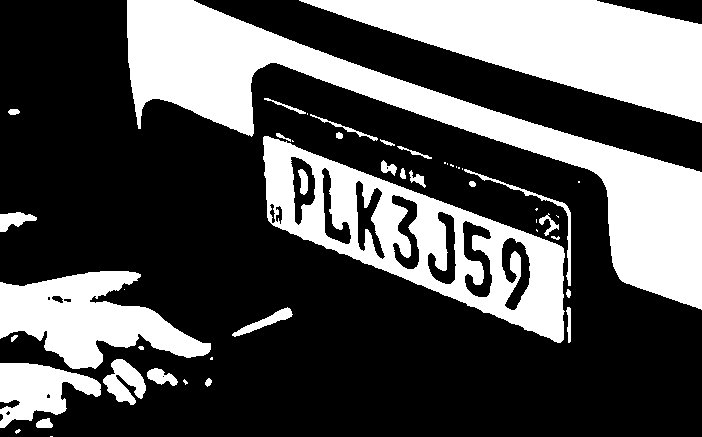

In [10]:
img2 = cv.imread(img_name,0)
th1_2,th2_2,th3_2 = find_threashholds(img2)

Acha o contorno da imagem

In [11]:
def find_contours(th1):

  #edged = cv.Canny(th1, 200, 200)
  #cv2_imshow(edged)

  contours,hierarchy = cv.findContours(th1,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

  drawing = np.zeros((th1.shape[0], th1.shape[1], 3), dtype=np.uint8)
  for i in range(len(contours)):
      color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
      cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
  cv2_imshow(drawing)
  return contours


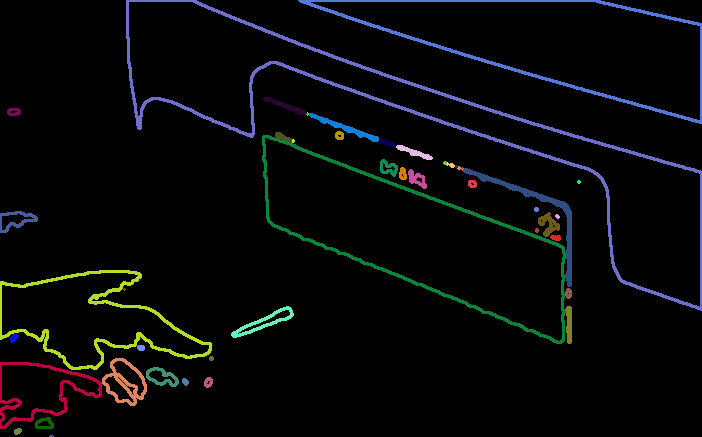

achou 47 contornos


In [12]:
contours_2 = find_contours(th1_2)
print(f"achou {len(contours_2)} contornos")

Aproxima os contornos para poligonos, e então acha retângulos

In [16]:
def find_rects(output,contours):
  rects = []
  #contour = 
  for i in range(len(contours)):
    #contour = max(contours, key = len)
    #contours.remove(max(contours, key = len))
    #contour = max(contours, key = len)

    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    # over a number of epsilon sizes
    for eps in np.linspace(0.001, 0.05, 10):
      #print(eps)
      # approximate the contour
      peri = cv.arcLength(contours[i], True)
      approx = cv.approxPolyDP(contours[i], eps * peri, True)
      # draw the approximated contour on the image

    if len(approx) == 4:
      convex = False
      #print(type(approx[0]))
      #print(approx[0].shape)
      angles = []
      for p in range(len(approx)):
        #print(square)
        #print(square[0])
        #print(square[0][0])
        #print(square[0][0][0])
        ba = approx[p-1][0] - approx[p][0]
        #print(ba)
        if p != len(approx)-1:
          bc = approx[p+1][0] - approx[p][0]
        else:
          bc = approx[0][0] - approx[p][0]
        #print(bc)
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        if (np.degrees(angle) < 29) or (np.degrees(angle) > 151):
          convex = True
        angles.append(np.degrees(angle))
        #print(f"angulo = {np.degrees(angle)}")
      #print(f"convex = {convex}")
      if (abs(angles[0]-angles[2])>30) or (abs(angles[1]-angles[3])>30):
        convex = True

      if not convex:
        area = shoelace_area(approx)
        #print(f"area = {area}")
        if area > 50:
          rects.append(approx)
          cv.drawContours(output, [approx], -1, color, 3)
          text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
      #cv.putText(output, text, (x, y - 15), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
      # show the approximated contour image
      #print("[INFO] {}".format(text))
  cv2_imshow(output)
  #print(rects)
  return rects

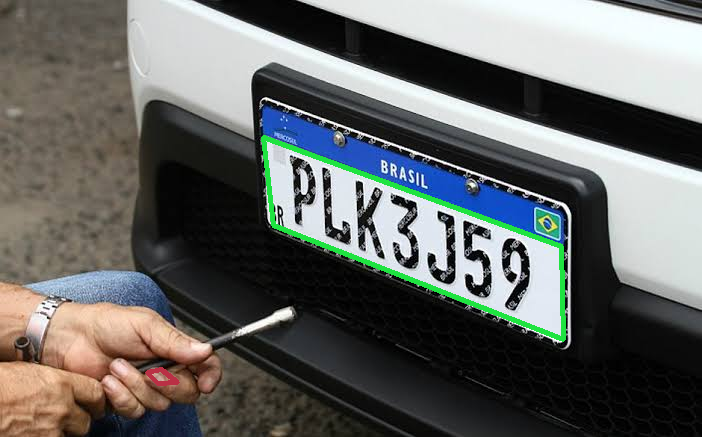

achou 2 retangulos


In [18]:
img_2 = cv.imread(img_name)
rects_2 = find_rects(img_2,contours_2)
print(f"achou {len(rects_2)} retangulos")

Repete os mesmos processos para a placa de referência

(384, 1180)


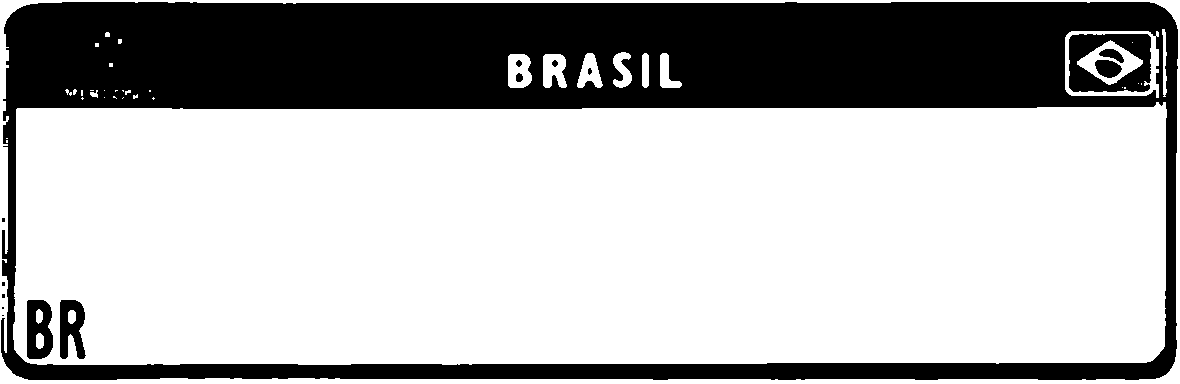

In [19]:
img1 = cv.imread(img_placa,0)
print(img1.shape)
th1_1,th2_1,th3_1 = find_threashholds(img1)

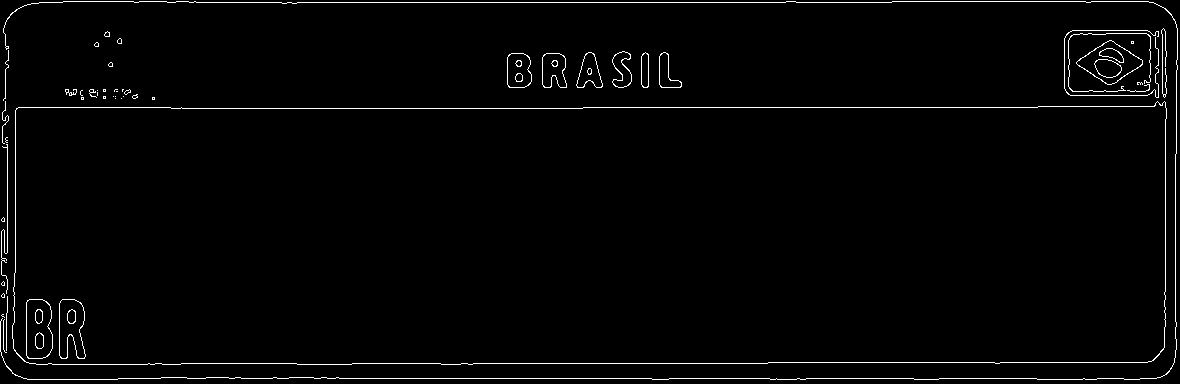

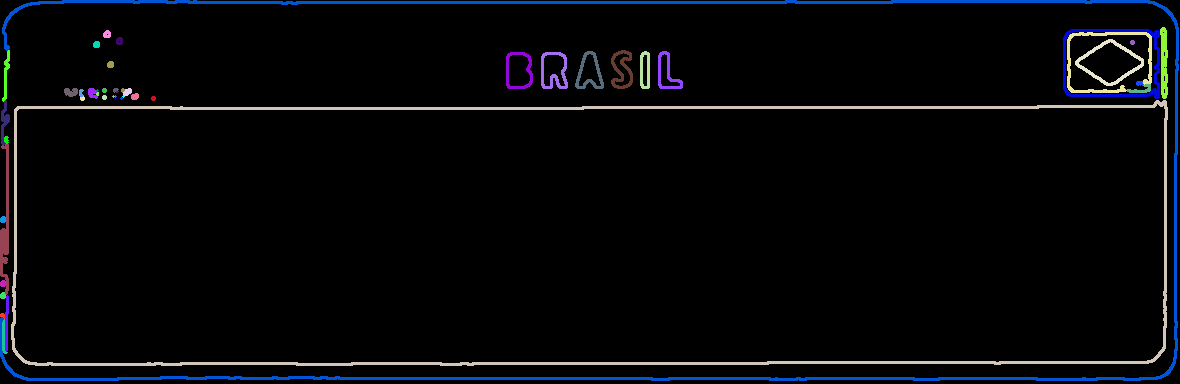

achou 48 contornos


In [20]:
edged1 = cv.Canny(th1_1, 200, 200)
cv2_imshow(edged1)
contours_1 = find_contours(edged1)
print(f"achou {len(contours_1)} contornos")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arccos


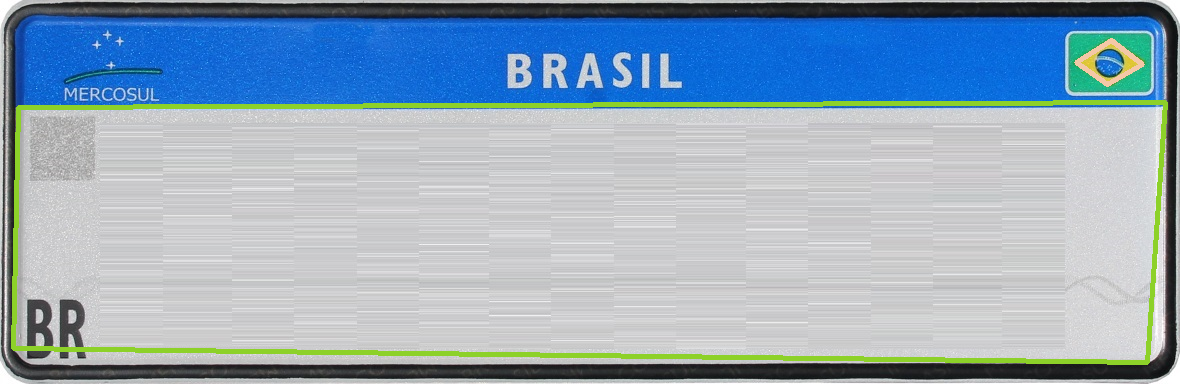

achou 2 retangulos


In [21]:
img_1 = cv.imread(img_placa)
rects_1 = find_rects(img_1,contours_1)
print(f"achou {len(rects_1)} retangulos")

Organisa os retângulos achados e acha equivalência entre os pontos do maior retângulo de cada imagem

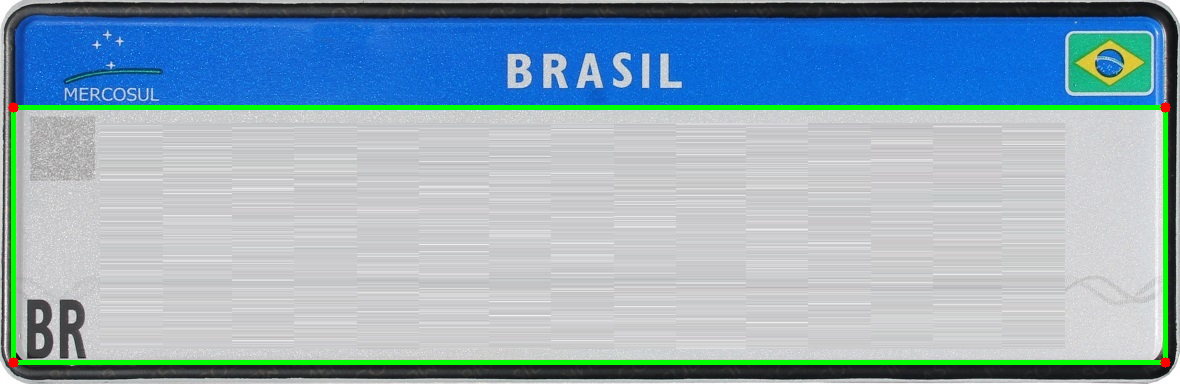

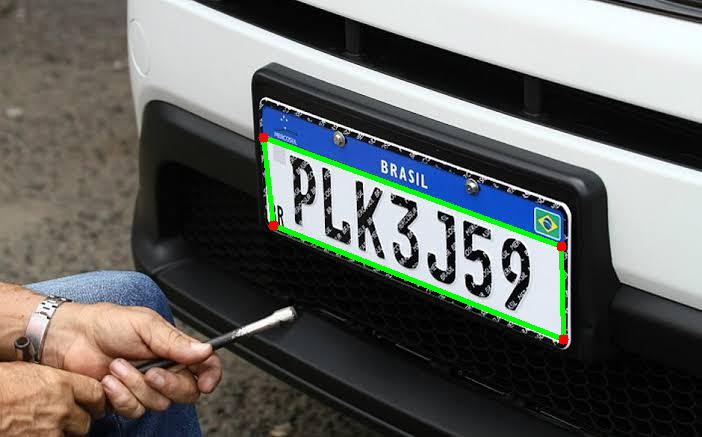

In [22]:
def config_rect(xy):
  if xy[0][0][0] < xy[-1][0][0]:
    xy[-1][0][0] = xy[0][0][0]
  else:
    xy[0][0][0] = xy[-1][0][0]

  if xy[1][0][0] > xy[2][0][0]:
    xy[2][0][0] = xy[1][0][0]
  else:
    xy[1][0][0] = xy[2][0][0]

  if xy[0][0][1] < xy[1][0][1]:
    xy[1][0][1] = xy[0][0][1]
  else:
    xy[0][0][1] = xy[1][0][1]

  if xy[2][0][1] > xy[3][0][1]:
    xy[3][0][1] = xy[2][0][1]
  else:
    xy[2][0][1] = xy[3][0][1]
  return xy

rect_reference = get_biggest(rects_1)

rect_reference = order_rect(rect_reference)


rect_reference = config_rect(rect_reference)
rect_reference = order_rect(rect_reference)


output1 = cv.imread(img_placa)
cv.drawContours(output1, [rect_reference], -1, (0,255,0), 3)
for (point) in rect_reference:

  cv.circle(output1, (int(point[0][0]), int(point[0][1])), 5, (0, 0, 255), -1)
cv2_imshow(output1)

rect_image = get_biggest(rects_2)
rect_image = order_rect(rect_image)

output2 = cv.imread(img_name)
cv.drawContours(output2, [rect_image], -1, (0,255,0), 3)
for (point) in rect_image:

  cv.circle(output2, (int(point[0][0]), int(point[0][1])), 5, (0, 0, 255), -1)
cv2_imshow(output2)



Acha homografia usando pontos dos retângulos, e aplica transformação de perspectiva à imagem analisada

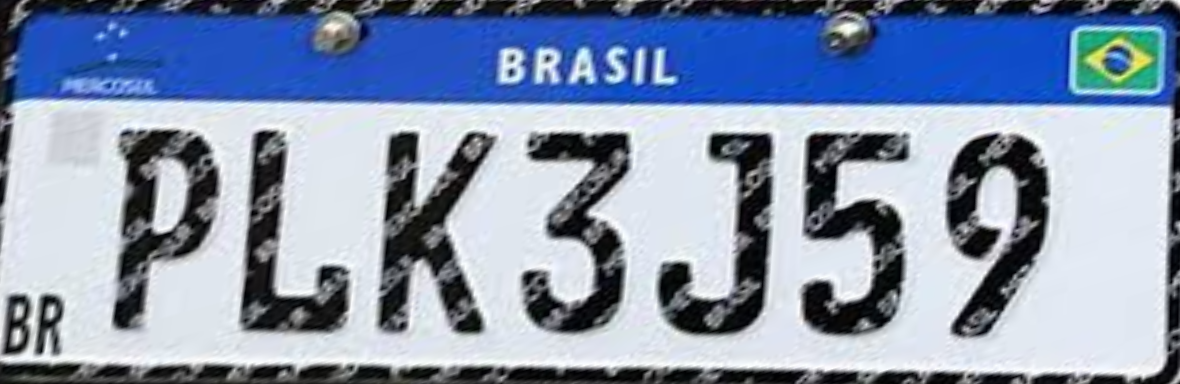

In [23]:
H, status = cv.findHomography(rect_image,rect_reference)

output = cv.imread(img_name)

out = cv.warpPerspective(output, H, (1180,384))

cv2_imshow(out)



Coloca a imagem em grayscale e equalisa o histograma

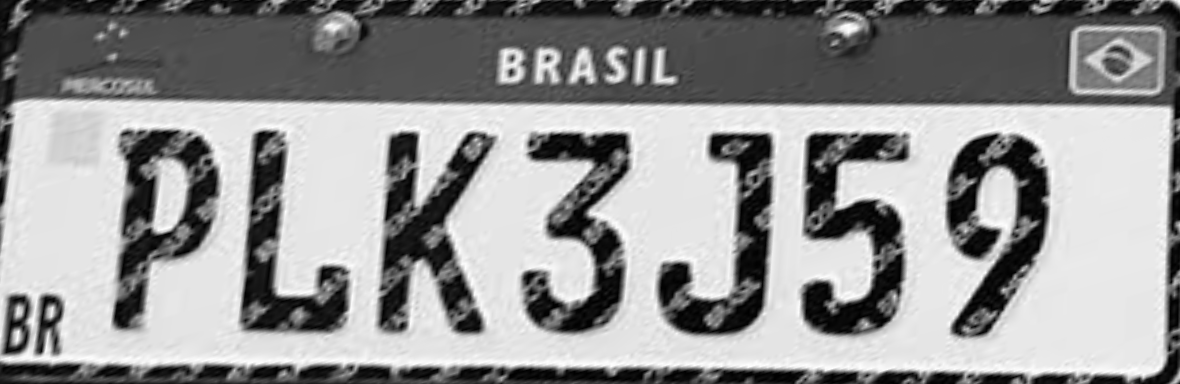

In [24]:
corrected = cv.cvtColor(out,cv.COLOR_BGR2GRAY)
cv2_imshow(corrected)
#edged = cv.Canny(corrected, 200, 200)
#cv2_imshow(edged)

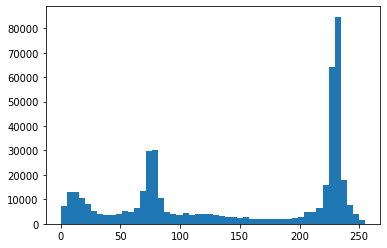

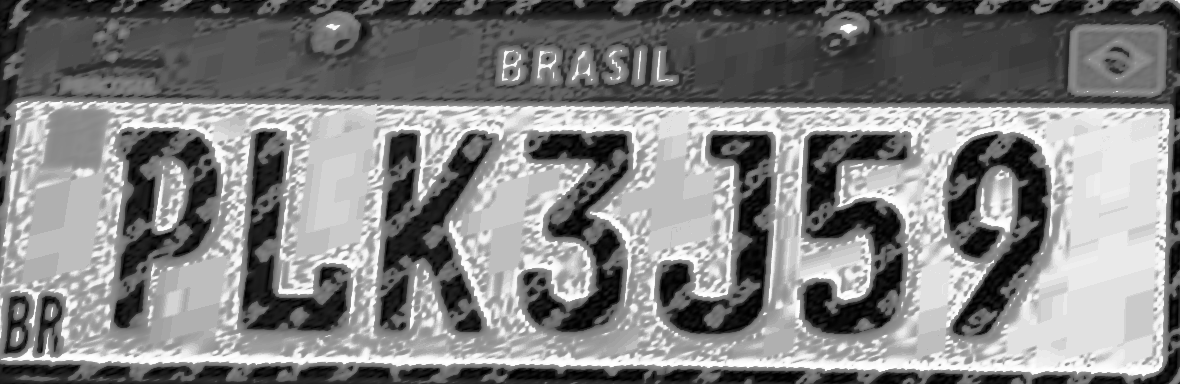

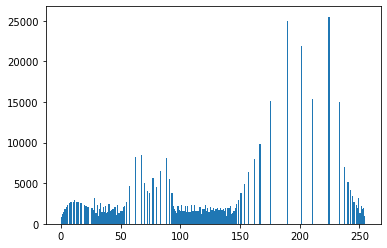

In [25]:
h=plt.hist(corrected.ravel(),bins=50,range=[0,255]) #ravel() transforma a imagem num vetor 1D
plt.show()
imgeq=cv.equalizeHist(corrected)
cv2_imshow(imgeq)
plt.hist(imgeq.ravel(),bins=256,range=[0,255]) 
plt.show()
#edged = cv.Canny(imgeq, 200, 200)
#cv2_imshow(edged)

Encontra threshhold binária

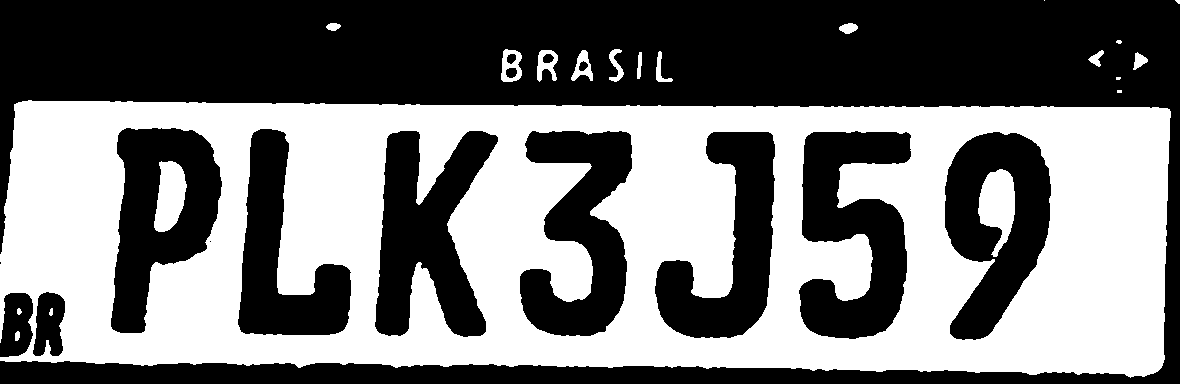

In [26]:

th1,th2,th3 = find_threashholds(imgeq)

Finalmente, aplica erosão

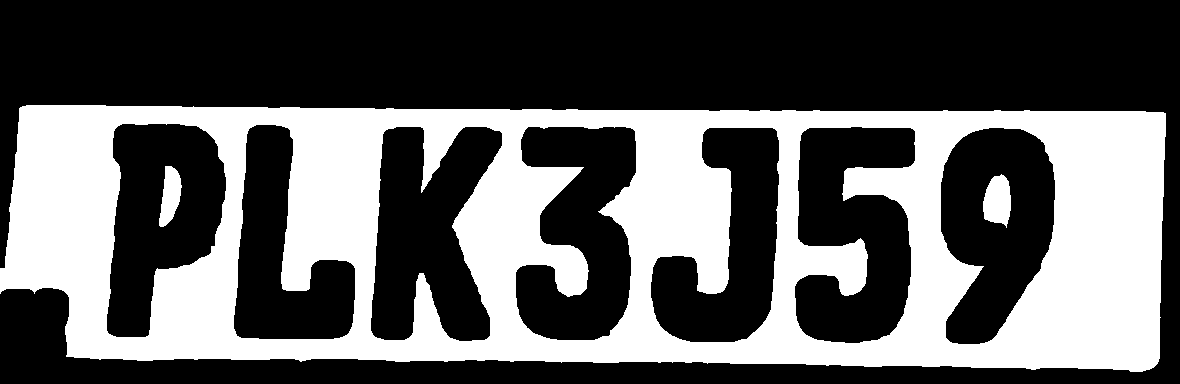

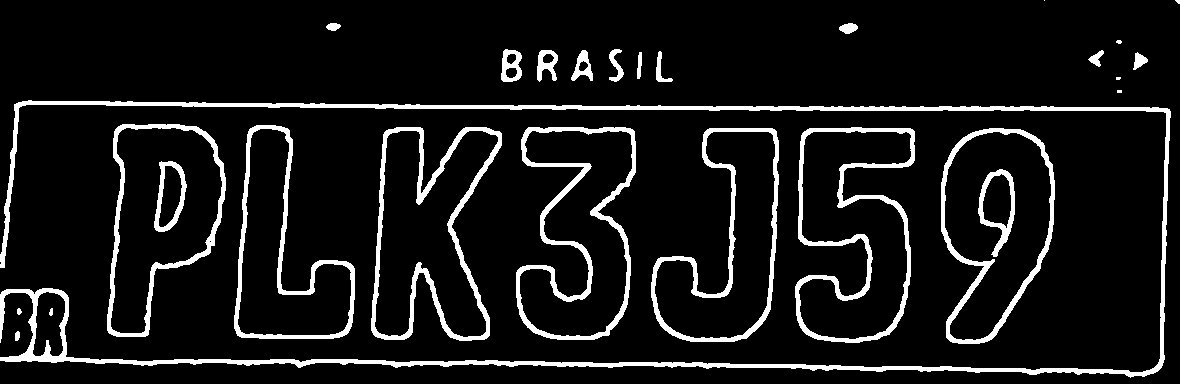

In [28]:
kernel = np.ones((3,3),np.uint8)
erosion = cv.erode(th1,kernel,iterations = 4)
cv2_imshow(erosion)
cont=th1-erosion
cv2_imshow(cont)

Pronto! A placa está muito mais legível!
Agora está muito mais fácil de ler a placa, ou de aplicar um software de detecção de texto caso desejado.

Outras visualisações abaixo:

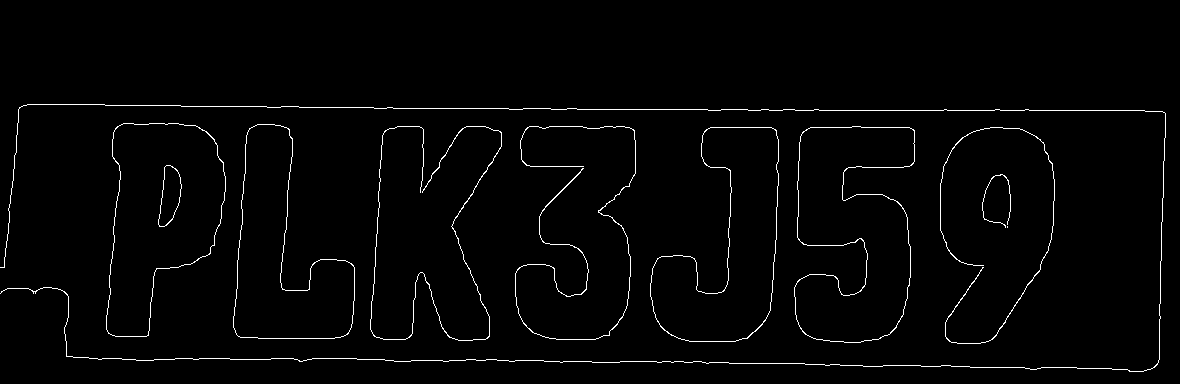

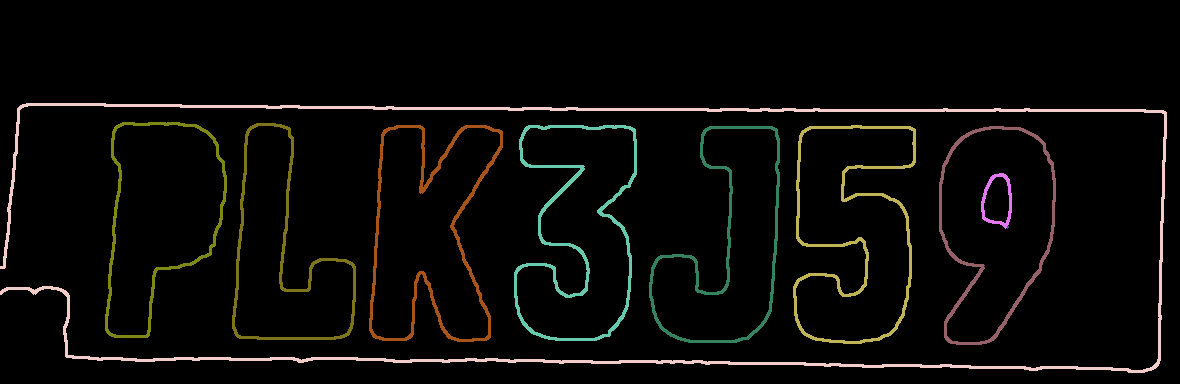

achou 10 contornos


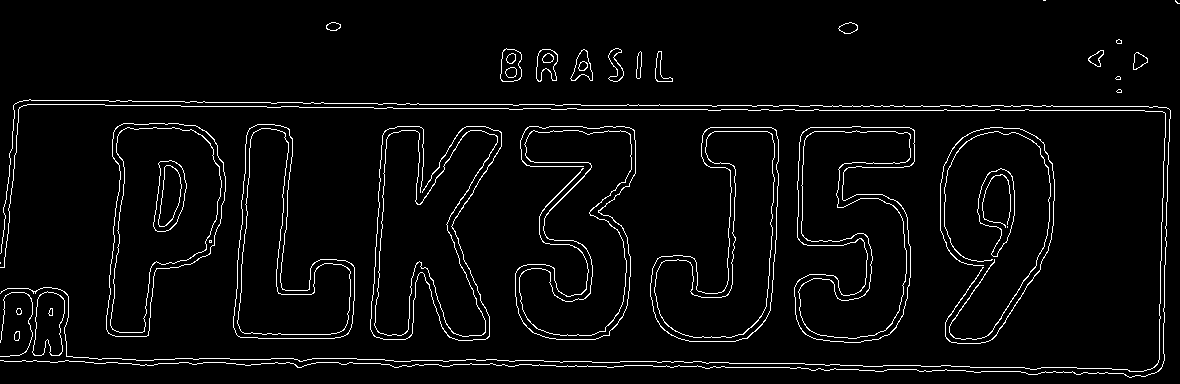

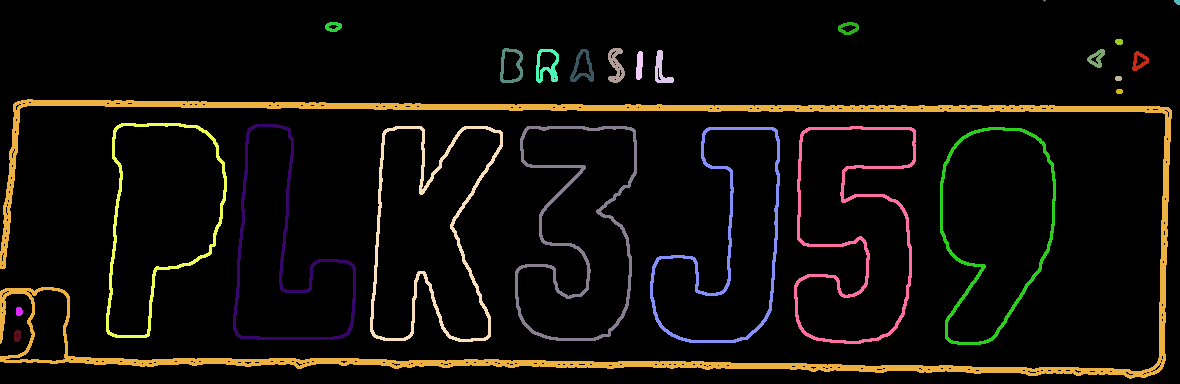

achou 25 contornos


In [29]:
edged = cv.Canny(erosion, 200, 200)
cv2_imshow(edged)
contours = find_contours(edged)
print(f"achou {len(contours)} contornos")

edged = cv.Canny(cont, 200, 200)
cv2_imshow(edged)
contours = find_contours(cont)
print(f"achou {len(contours)} contornos")

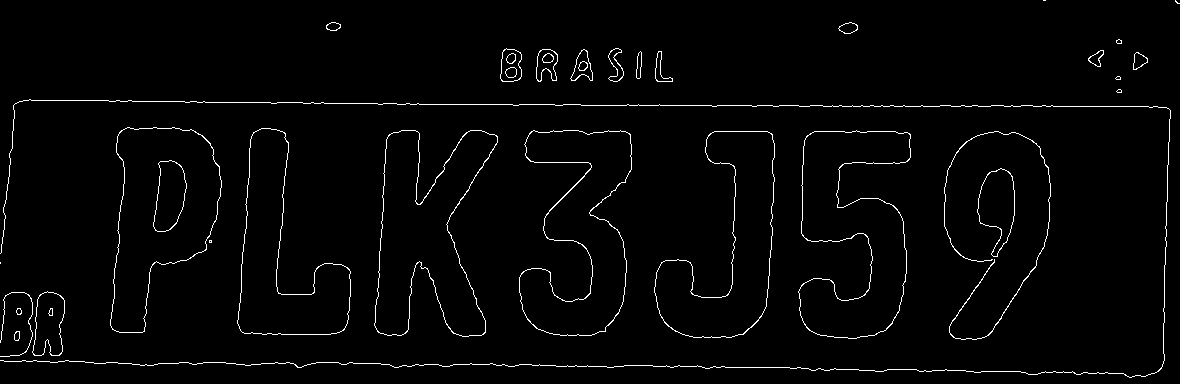

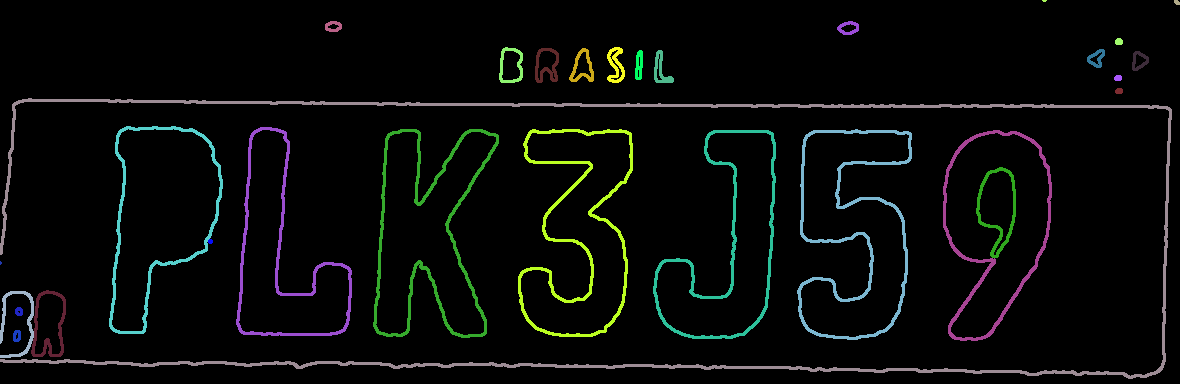

achou 30 contornos


In [30]:
edged = cv.Canny(th1, 200, 200)
cv2_imshow(edged)
contours = find_contours(edged)
print(f"achou {len(contours)} contornos")